In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import mss
import uuid
import mss.tools
import time
import keyboard
import pyautogui
import math


In [ ]:
time.sleep(5)
 
with mss.mss() as sct:
    monitor_info = sct.monitors[0]
    top_margin = monitor_info["height"] // 3
    monitor = {"top": monitor_info["top"] + top_margin, "left": monitor_info["left"]+55, "width": monitor_info["width"]-120, "height": (monitor_info["height"] * 2 // 3)-55}
 
    while not keyboard.is_pressed("space"):
        output = f"dataset/{str(uuid.uuid4())}.png".format(**monitor)
        sct_img = sct.grab(monitor)
        mss.tools.to_png(sct_img.rgb, sct_img.size, output=output)
        print(f"Captured {output}")
        time.sleep(0.5)

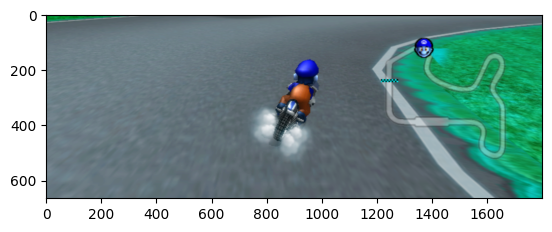

In [12]:
# import the image
img_orig = cv2.imread('dataset/1489e9b8-f955-4a1c-a80d-f2b3d4207113.png')
plt.imshow(img_orig)

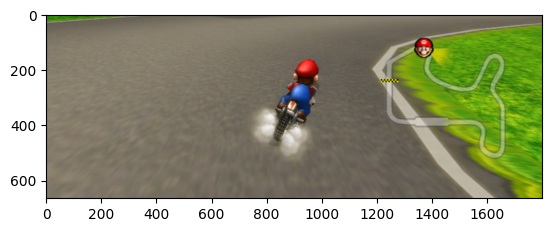

In [13]:
img_rgb = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)

(-0.5, 1799.5, 664.5, -0.5)

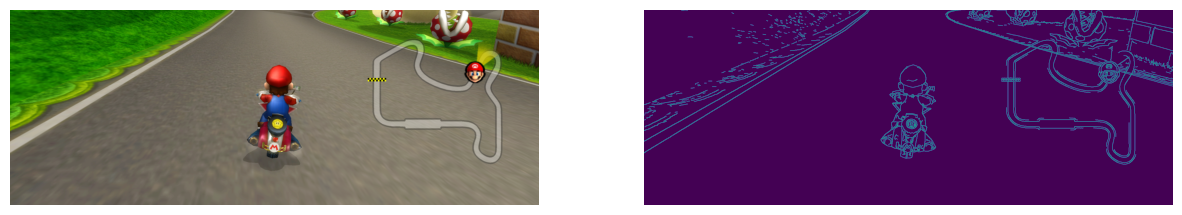

In [14]:
img_orig = cv2.imread('dataset/9f191f48-fc18-42f2-b2cf-9badd9ae2192.png')
img_rgb = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)

# canny detection without blurring
img_canny = cv2.Canny(img_orig, threshold1=121.6, threshold2=180.9)
plt.figure(figsize = (15, 15))
plt.subplot(1, 2, 1); plt.imshow(img_rgb)
plt.axis('off')
plt.subplot(1, 2, 2); plt.imshow(img_canny)
plt.axis('off')

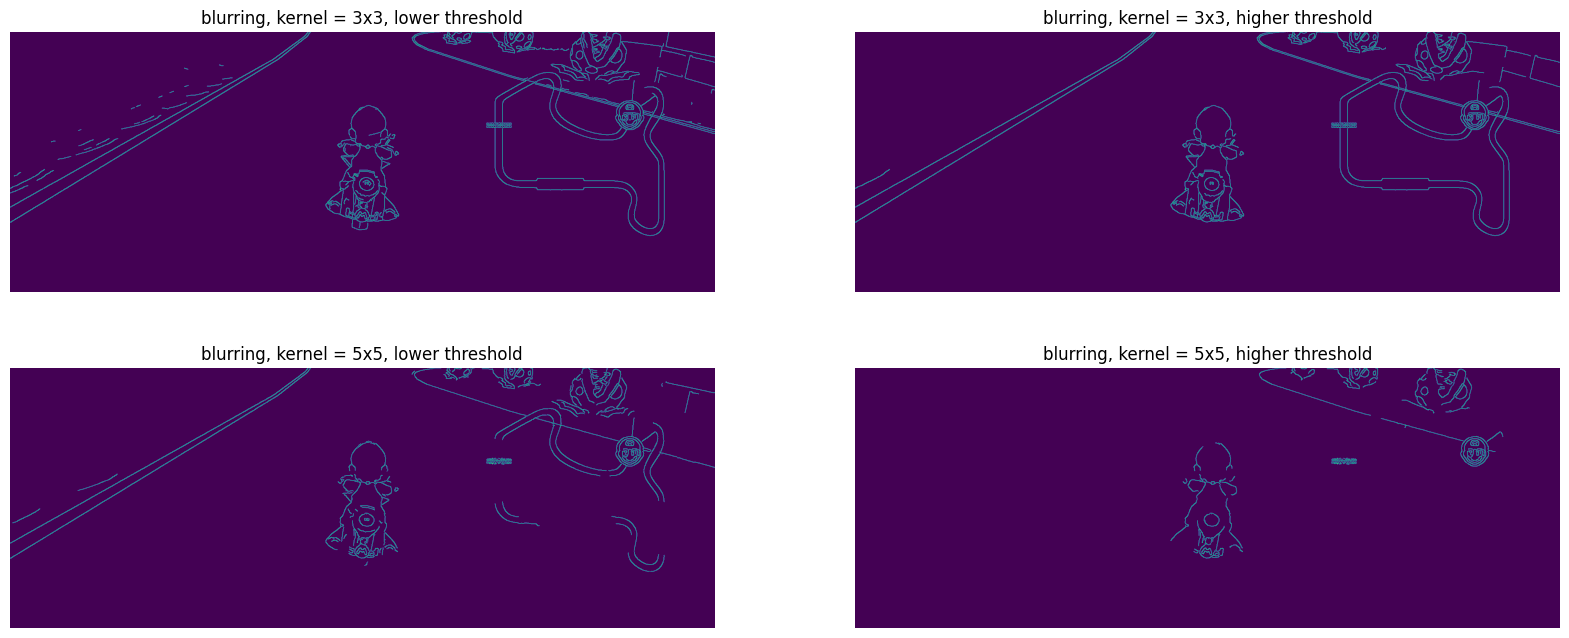

In [15]:
# set the lower and upper threshold
med_val = np.median(img_orig)
lower = 121.6
upper = 180.9


# blurring with ksize = 3
img_k3 = cv2.blur(img_orig, ksize = (3, 3))
# canny detection with different thresholds
edges_k3 = cv2.Canny(img_k3, threshold1 = lower, threshold2 = upper)
edges_k3_2 = cv2.Canny(img_k3, lower, upper + 75)

# blurring with ksize = 5 
img_k5 = cv2.blur(img_orig, ksize = (5, 5))
# canny detection with different thresholds
edges_k5 = cv2.Canny(img_k5, lower, upper)
edges_k5_2 = cv2.Canny(img_k5, lower, upper + 75)

# plot the images
images = [edges_k3, edges_k3_2, edges_k5, edges_k5_2]
titles = ['blurring, kernel = 3x3, lower threshold', 
          'blurring, kernel = 3x3, higher threshold', 
          'blurring, kernel = 5x5, lower threshold', 
          'blurring, kernel = 5x5, higher threshold']
plt.figure(figsize = (20, 8))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(images[i])
    plt.axis('off')
    plt.title(titles[i])
        
plt.show()

PLACE THE RED AND BLACK IMG HERE!!!!!

(-0.5, 1799.5, 664.5, -0.5)

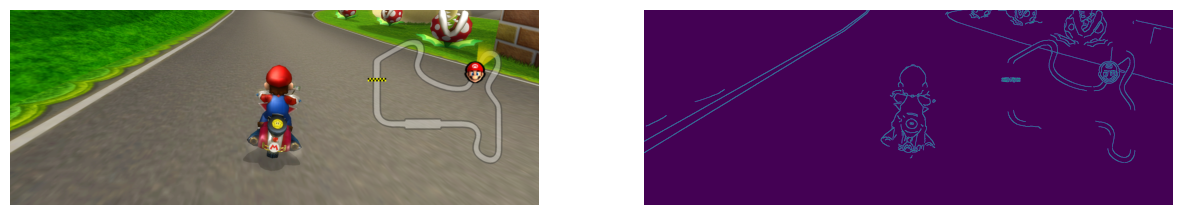

In [16]:
img_orig = cv2.imread('dataset/9f191f48-fc18-42f2-b2cf-9badd9ae2192.png')
img_rgb = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)

# canny detection with blurring
img_blur = cv2.blur(img_orig, ksize = (5, 5))
img_canny = cv2.Canny(img_blur, threshold1=121.6, threshold2=180.9)
plt.figure(figsize = (15, 15))
plt.subplot(1, 2, 1); plt.imshow(img_rgb)
plt.axis('off')
plt.subplot(1, 2, 2); plt.imshow(img_canny)
plt.axis('off')

### The working code

In [9]:
# actual test
def screenshot():
    with mss.mss() as sct:
        time.sleep(1)
        monitor_info = sct.monitors[0]
        top_margin = (monitor_info["height"] // 3) + 50
        monitor = {"top": monitor_info["top"] + top_margin, "left": monitor_info["left"] + 55, "width": monitor_info["width"] - 120, "height": (monitor_info["height"] * 2 // 3)-105}
        output = f"testimages/{str(uuid.uuid4())}.png".format(**monitor)
        sct_img = sct.grab(monitor)
        mss.tools.to_png(sct_img.rgb, sct_img.size, output=output)
    return output
            
def drive():
    img_path = screenshot()
    img_orig = cv2.imread(img_path)
    img_blur = cv2.blur(img_orig, ksize=(5, 5))
    img_canny = cv2.Canny(img_blur, threshold1=121.6, threshold2=180.9)
    cdst = cv2.cvtColor(img_canny, cv2.COLOR_GRAY2RGB)
    linesP = cv2.HoughLinesP(img_canny, 1, np.pi / 250, 90, None, 94.6, 20.5)
    
    if linesP is not None:
        for i in range(0, len(linesP)):
            l = linesP[i][0]
            cv2.line(cdst, (l[0], l[1]), (l[2], l[3]), (0, 0, 255), 3, cv2.LINE_AA)
    
    image_width = 1800
    threshold = image_width // 2  # Half of the image width

    # Separate left and right coordinates based on the threshold
    left_y = []
    left_x = []
    right_y = []
    right_x = []
    if linesP is not None:
        for line in linesP:
            x1, y1, x2, y2 = line[0]
            # Separate coordinates into left and right sides
            if x1 < threshold and x2 < threshold:
                left_y.extend([y1, y2])
                left_x.extend([x1, x2])
            elif x1 >= threshold and x2 >= threshold:
                right_y.extend([y1, y2])
                right_x.extend([x1, x2])

    # Find the lowest Y coordinates on the left and right sides
    if left_y:
        left_lowest_index = left_y.index(min(left_y))
        x1_left_lowest, y1_left_lowest = left_x[left_lowest_index], left_y[left_lowest_index]
        cv2.circle(cdst, (x1_left_lowest, y1_left_lowest), 10, (0, 0, 255), -1)  # Mark left lowest point in red

    if right_y:
        right_lowest_index = right_y.index(min(right_y))
        x2_right_lowest, y2_right_lowest = right_x[right_lowest_index], right_y[right_lowest_index]
        cv2.circle(cdst, (x2_right_lowest, y2_right_lowest), 10, (0, 0, 255), -1)  # Mark right lowest point in red


    if right_y and not left_y:
        label = 'right'
        print("right line only")
        return label
        
    elif left_y and not right_y:
        label = 'left'
        print("left line only")
        return label
    elif not left_y and not right_x:
        label = 'back'
        return label
    elif right_y and left_y:
        # Calculate Euclidean distance
        distance = math.sqrt((x2_right_lowest - x1_left_lowest)**2 + (y2_right_lowest - y1_left_lowest)**2)

        print("Distance between the points:", distance)

        center = distance / 2
        print('center:', center)

        desired_x_point = x1_left_lowest + center
        mario_x_point = 900

        print('Desired x point:', desired_x_point)
        print(desired_x_point - mario_x_point)
        
        direction = desired_x_point - mario_x_point
        if(direction > 0 and direction < 80):
            label = 'forward'
        if(direction < 0 ):
            label = 'left'
        if(direction > 80):
            label = 'right'
        

        print(label)
        return label
   

def move():
    label = drive()
    print(label)
    if (label == 'right'):
        keyboard.press('d')
        pyautogui.mouseDown(button='left')
        time.sleep(0.15)
        pyautogui.mouseUp(button='left')
        keyboard.release('d')
    if (label == 'left'):
        keyboard.press('q')
        pyautogui.mouseDown(button='left')
        time.sleep(0.15)
        pyautogui.mouseUp(button='left')
        keyboard.release('q')
    if(label == 'forward'):
        pyautogui.mouseDown(button='left')
        time.sleep(0.3)
        pyautogui.mouseUp(button='left')
    if(label == 'back'):
        pyautogui.mouseDown(button='right')
        time.sleep(0.3)
        pyautogui.mouseUp(button='right')

time.sleep(5)
while not keyboard.is_pressed("space"):
    move()

Distance between the points: 844.0005924168537
center: 422.00029620842685
Desired x point: 888.0002962084268
-11.99970379157321
left
left
Distance between the points: 601.568782434727
center: 300.7843912173635
Desired x point: 1050.7843912173635
150.78439121736346
right
right
Distance between the points: 851.002350173018
center: 425.501175086509
Desired x point: 895.501175086509
-4.498824913491035
left
left
Distance between the points: 520.3556476103628
center: 260.1778238051814
Desired x point: 1088.1778238051813
188.17782380518133
right
right
Distance between the points: 869.0368231553828
center: 434.5184115776914
Desired x point: 957.5184115776914
57.51841157769138
forward
forward
Distance between the points: 842.0213774008354
center: 421.0106887004177
Desired x point: 978.0106887004176
78.01068870041763
forward
forward
Distance between the points: 648.0694407237545
center: 324.03472036187725
Desired x point: 1016.0347203618772
116.03472036187725
right
right
Distance between the poi